In [1]:
import warnings
warnings.simplefilter(action = 'ignore')

from anisotropy.database import Database, tables
import pathlib
import peewee as pw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
db = Database(pathlib.Path("anisotropy.db").resolve())
execution = 5

In [3]:
def load_data(execution: int, field: str):
    if not db.getExecution(execution):
        print("Execution not found")

    for model in db.tables:
        try:
            column = getattr(model, field)
        
        except AttributeError:
            pass

        else:
            break

    query = model.select(tables.Shape.alpha, column, tables.Shape.direction, tables.Shape.label)
    idn = db.tables.index(model)

    for table in reversed(db.tables[ :idn]):
        query = query.join(table, pw.JOIN.LEFT_OUTER)
        
    query = query.switch(tables.Shape)
    query = query.where(
        tables.Shape.exec_id == execution,
    #    tables.Shape.label == structure,
    )
    query = query.order_by(tables.Shape.label, tables.Shape.direction, tables.Shape.alpha)

    with db:
        if query.exists():
            table = []
            for row in query.dicts():
                for k in row.keys():
                    if type(row[k]) == list:
                        row[k] = str(row[k])

                table.append(row)
        
        else:
            table = None

    if table is None:
        print("Results not found")

    else:
        return pd.DataFrame(table)

def permeability(label, direction):
    def concrete(execution, field):
        df = load_data(execution, field)
        return df[df.label == label][df.direction == direction][field].to_numpy()

    alpha = concrete(7, "alpha")
    viscosity = concrete(5, "viscosity")
    viscosityKinematic = concrete(5, "viscosityKinematic")
    length = concrete(7, "length")
    flowRate = concrete(5, "flowRate")
    areaCellOutlet = concrete(7, "areaCellOutlet")
    pressureInlet = concrete(5, "pressureInlet")
    pressureOutlet = concrete(5, "pressureOutlet")
    density = concrete(5, "density")

    return viscosity * length * flowRate / (areaCellOutlet * (pressureInlet - pressureOutlet))

def nanmean(arr):
    temp = arr.copy()

    if np.isnan(temp[0]):
        temp[0] = temp[1]

    for n, item in enumerate(temp):
        if np.all(np.isnan(item)):
            
            vals = temp[n - 1 : n + 2]

            if np.sum(~np.isnan(vals)) <= 1:
                vals = temp[n - 2 : n + 3]

            temp[n] = vals[~np.isnan(vals)].mean()

    return temp

def filter_group(arr, nan = True, qhigh = True, quantile = 0.97):
    temp = arr.copy()
    check = True
    quan = np.quantile(temp[~np.isnan(temp)], quantile)
    limit = 1000

    while check:
        if nan and np.any(np.isnan(temp)):
            temp = nanmean(temp)
            check = True
        
        elif qhigh and np.any(quan < temp):
            temp[quan < temp] = np.nan
            check = True

        else:
            check = False 
        
        if limit <= 0:
            break

        else:
            limit -= 1

    return temp

In [4]:
plt.rcParams.update({
    "font.size": 18,
    "lines.markersize": 9.0,
    "lines.linewidth": 3
})
savefig = True
anisotropy = pd.DataFrame({"simple": None, "bodyCentered": None, "faceCentered": None}, index = ["A21", "A31"])

Porosity

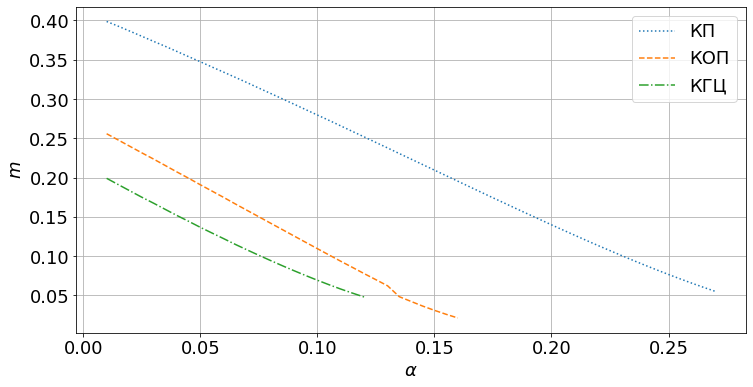

In [57]:
df = load_data(execution, "porosity")
alpha = df["alpha"].unique()
simple = df[df.label == "simple"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
bodyCentered = df[df.label == "bodyCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
faceCentered = df[df.label == "faceCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))

ax.plot(alpha, np.pad(simple, (0, alpha.size - simple.size), 'constant', constant_values = np.nan), ":", label = "КП")
ax.plot(alpha, np.pad(bodyCentered, (0, alpha.size - bodyCentered.size), 'constant', constant_values = np.nan), "--", label = "КОП")
ax.plot(alpha, np.pad(faceCentered, (0, alpha.size - faceCentered.size), 'constant', constant_values = np.nan), "-.", label = "КГЦ")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$m$")
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig("porosity-rounded.tiff")

Simple structure

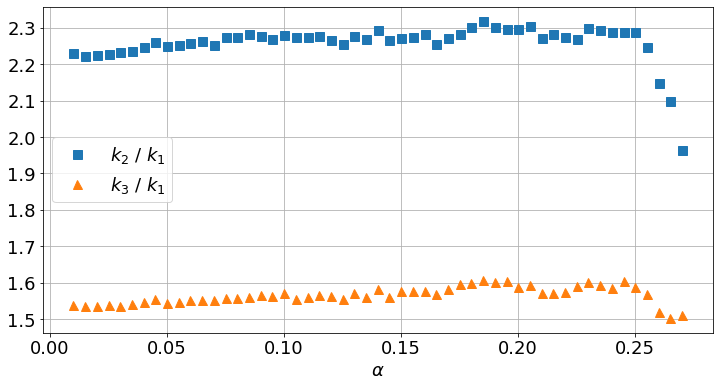

In [69]:
df = load_data(execution, "flowRate")
simple = df[df.label == "simple"].groupby(df.direction)
alpha = simple.get_group("[0.0, 0.0, 1.0]")["alpha"].to_numpy()

k1 = (permeability("simple", "[0.0, 0.0, 1.0]"))
k2 = (permeability("simple", "[1.0, 0.0, 0.0]"))
k3 = (permeability("simple", "[1.0, 1.0, 1.0]"))

#poly = np.polynomial.Polynomial.fit(alpha, anisotropy_21, 1)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))
ax.plot(alpha, k2 / k1, "s", label = "$k_2$ / $k_1$")
ax.plot(alpha, k3 / k1, "^", label = "$k_3$ / $k_1$")
#ax.plot(alpha, poly(alpha), "-")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
#plt.ylabel("Анизотропия проницаемости")
#plt.title("Простая кубическая")
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig("anisotropy-simple.tiff")

In [70]:
anisotropy["simple"] = [(k2 / k1).mean(), (k3 / k1).mean()]

Body-centered structure

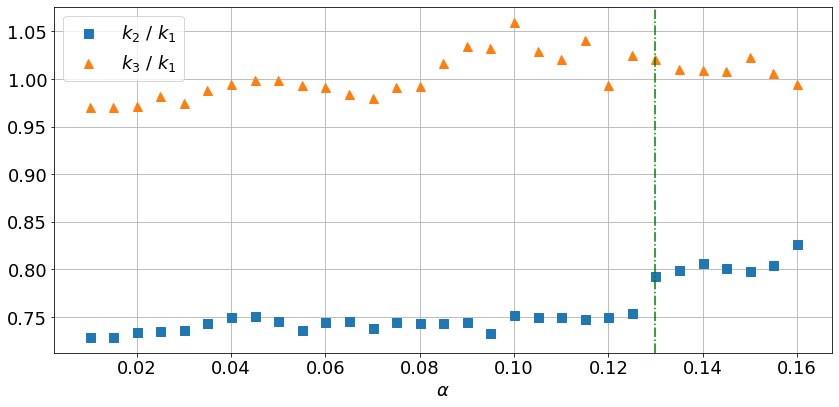

In [71]:
df = load_data(execution, "flowRate")
bodyCentered = df[df.label == "bodyCentered"].groupby(df.direction)
alpha = bodyCentered.get_group("[0.0, 0.0, 1.0]")["alpha"].to_numpy()

k1 = filter_group(permeability("bodyCentered", "[0.0, 0.0, 1.0]"))
k2 = filter_group(permeability("bodyCentered", "[1.0, 0.0, 0.0]"))
k3 = filter_group(permeability("bodyCentered", "[1.0, 1.0, 1.0]"))

#poly = np.polynomial.Polynomial.fit(alpha, anisotropy_21, 10)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))
ax.plot(alpha, k2 / k1, "s", label = r"$k_2$ / $k_1$")
ax.plot(alpha, k3 / k1, "^", label = r"$k_3$ / $k_1$")
ax.axvline(0.13, linestyle = "-.", color = "green")
#ax.plot(alpha, poly(alpha), "-")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
#plt.ylabel("Анизотропия проницаемости")
#plt.title("Кубическая объемноцентрированная")

if savefig:
    fig.tight_layout()
    fig.savefig("anisotropy-bodycentered.tiff")

In [72]:
anisotropy["bodyCentered"] = [(k2 / k1).mean(), (k3 / k1).mean()]

Face-centered structure

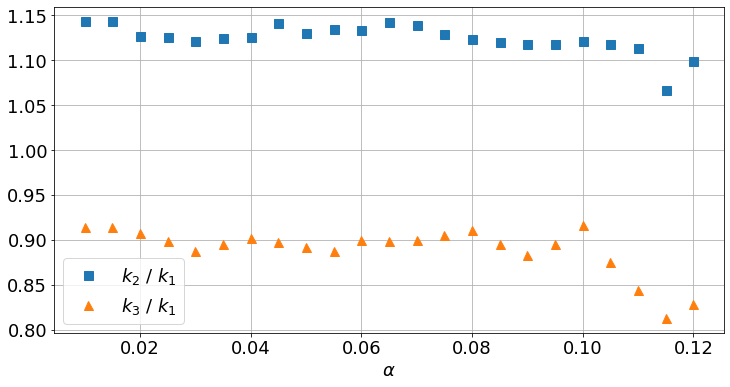

In [73]:
df = load_data(execution, "flowRate")
faceCentered = df[df.label == "faceCentered"].groupby(df.direction)
alpha = faceCentered.get_group("[0.0, 0.0, 1.0]")["alpha"].to_numpy()

k1 = filter_group(permeability("faceCentered", "[0.0, 0.0, 1.0]"))
k2 = filter_group(permeability("faceCentered", "[1.0, 0.0, 0.0]"))
k3 = filter_group(permeability("faceCentered", "[1.0, 1.0, 1.0]"))

#poly = np.polynomial.Polynomial.fit(alpha, anisotropy_21, 10)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))
ax.plot(alpha, filter_group(k2 / k1, quantile = 0.97), "s", label = r"$k_2$ / $k_1$")
ax.plot(alpha, filter_group(k3 / k1, quantile = 0.8), "^", label = r"$k_3$ / $k_1$")
#ax.plot(alpha, poly(alpha), "-")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
#plt.ylabel("Анизотропия проницаемости")
#plt.title("Кубическая гранецентрированная")
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig("anisotropy-facecentered.tiff")

In [74]:
anisotropy["faceCentered"] = [(k2 / k1).mean(), (k3 / k1).mean()]

Anisotropy mean values

In [78]:
anisotropy.round(4)

,simple,bodyCentered,faceCentered
A21,2.2591,0.7571,1.1312
A31,1.5660,1.0036,0.9148


Analytical porosity

In [5]:
def porosity_a(a, label):
    if label == "simple":
        val = (1 - np.pi * (2 - 3 * a ** 2 * (3 - a)) / (12 * (1 - a) ** 3))

    elif label == "bodyCentered":
        a13 = a[a <= 0.134]
        a13g = a[a > 0.134]
        a = a13
        val = (1 - np.pi * np.sqrt(3) * (1 - 2 * a ** 2 * (3 - a)) / (8 * (1 - a) ** 3)
        )
        a = a13g
        val2 = (1 - np.pi * np.sqrt(3) * (1 - 2 * a ** 2 * (3 - a)) / (8 * (1 - a) ** 3) +
            np.pi * (np.sqrt(3) - 2 * (1 - a)) ** 2 * 
            (np.sqrt(3) - (1 - a)) / (8 * (1 - a)**3)
        )
        val = np.append(val, val2)

    elif label == "faceCentered":
        val = (1 - np.pi * (1 - 3 * a ** 2 * (3 - a)) / (3 * np.sqrt(2) * (1 - a) ** 3))

    return val

def pad(x, y):
    return np.pad(y, (0, x.size - y.size), 'constant', constant_values = np.nan)

In [6]:
alpha = np.linspace(0, 0.3, 50)
porosity_simple = porosity_a(alpha[alpha <= 0.2929], "simple")
porosity_bodyCentered = porosity_a(alpha[alpha <= 0.1835], "bodyCentered")
porosity_faceCentered = porosity_a(alpha[alpha <= 0.134], "faceCentered")

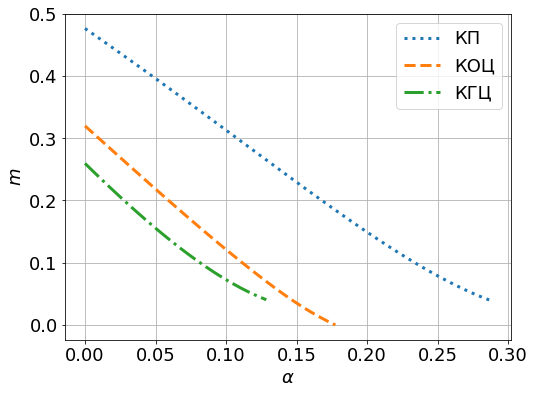

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))

ax.plot(alpha, pad(alpha, porosity_simple), ":", label = "КП")
ax.plot(alpha, pad(alpha, porosity_bodyCentered), "--", label = "КОЦ")
ax.plot(alpha, pad(alpha, porosity_faceCentered), "-.", label = "КГЦ")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$m$")
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig("porosity-analytical.tiff")

In [131]:
df = load_data(execution, "porosity")
alpha = df["alpha"].unique()
simple = df[df.label == "simple"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
bodyCentered = df[df.label == "bodyCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
faceCentered = df[df.label == "faceCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()

part_simple = pad(alpha, simple)[alpha <= 0.29] / porosity_a(alpha[alpha <= 0.29], "simple")
part_bodyCentered = pad(alpha, bodyCentered)[alpha <= 0.18] / porosity_a(alpha[alpha <= 0.18], "bodyCentered")
part_faceCentered = pad(alpha, faceCentered)[alpha <= 0.13] / porosity_a(alpha[alpha <= 0.13], "faceCentered")


In [145]:
porosity_a(alpha[alpha <= 0.18], "bodyCentered").size

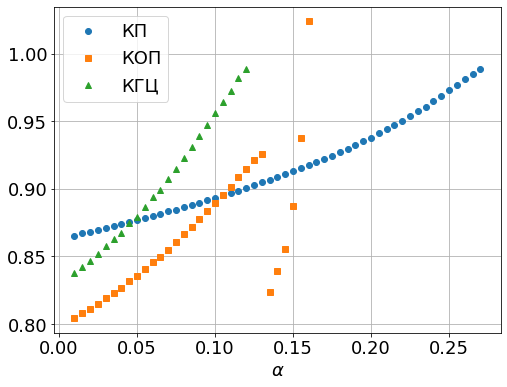

In [151]:
plt.rcParams.update({
    "lines.markersize": 6.0
})
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))

ax.plot(alpha, pad(alpha, part_simple), "o", label = "КП")
ax.plot(alpha, pad(alpha, part_bodyCentered), "s", label = "КОП")
ax.plot(alpha, pad(alpha, part_faceCentered), "^", label = "КГЦ")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
#plt.ylabel(r"")
plt.show()

if savefig:
    fig.tight_layout()
    fig.savefig("porosity-proportion.tiff")

In [152]:
part_simple.mean()

In [154]:
part_bodyCentered[~np.isnan(part_bodyCentered)].mean()

In [155]:
part_faceCentered[~np.isnan(part_faceCentered)].mean()